In [65]:
import pandas as pd
import torch
import os
import time
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, accuracy_score, confusion_matrix
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import (
    BertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    AdamW,
    Adafactor,
    get_linear_schedule_with_warmup,
    logging,
)
from simpletransformers.classification import ClassificationModel

In [32]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  device = torch.device("cuda")
  print('GPU:', torch.cuda.get_device_name(0))
else:
  raise SystemError('GPU device not found')

GPU: NVIDIA A100-SXM4-40GB


In [34]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True, use_cuda=torch.cuda.is_available())

In [35]:
df = pd.read_csv('/content/drive/MyDrive/Nane&Limon/Dataset/teknofest_train_final.csv',sep="|")
df = pd.DataFrame(df, columns=['text', 'target'])

In [36]:
le = LabelEncoder()
df["target"] = le.fit_transform(df.target)

In [37]:
print(df['target'].unique())
print(df.head())

[0 3 4 2 1]
                                                text  target
0                                        çürük dişli       0
1  Bu adamın islama ve müslümanlara verdiği zarar...       3
2                               erkekler zora gelmez       4
3  Utanmazın götüne kazık sokmuşlar bu tıkırtı ne...       2
4     otomasyon< sistemlerine= doğrudan bağlanabilir       1


In [38]:
training = df.groupby('target').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

In [39]:
training.reset_index(drop=True)

,text,target
0,beynin seni terkedeli çok olmuş,0
1,ne cırtlak bi sese sahipsin,0
2,Biraz daha yersen balinadan farkın kalmıyacak,0
3,sen daha dünki yeni yetme küçük sünepe,0
4,kus beyinli git kendine sakla aklini,0
...,...,...
10089,Kadın dediğin evinde oturur çocuğuna bakar,4
10090,Kızı olanın dili olmaz,4
10091,Kadın dayak yesede susmalı,4
10092,Elinin hamuruyla erkek işine karışma,4


In [40]:
test.reset_index(drop=True)

,text,target
0,otomasyon< sistemlerine= doğrudan bağlanabilir,1
1,Kadın yönetici sayısı oldukça az olduğu için ş...,4
2,makara bunu duyunca avluya çıkmış ve kızağa sa...,1
3,işe yaramaz herif,0
4,annenin babası bir türk bile olsa umurumda değ...,3
...,...,...
2491,en birinci emelleri oğullarına yahut kardeşler...,1
2492,hiçbir tane de mi ceren gözlü kürt kızı yok,1
2493,yanlarında bir de ermeni papaz vardır,1
2494,macaristandan almanyaya fon tepkisi macaristan...,1


In [41]:
model = ClassificationModel('bert', 'dbmdz/bert-base-turkish-128k-uncased',
                        num_labels=5,
                        args={'reprocess_input_data': True,
                        'overwrite_output_dir': True,
                        'num_train_epochs': 3,
                        "output_dir": "bert_model",
                        "warmup_steps": 100,
                        "weight_decay":0,
                        "load_best_model_at_end": True,
                        "use_early_stopping": True,
                        "early_stopping_patience": 5,
                        "early_stopping_delta": 0.001,
                        "max_length": 80,
                        "tokenizer_name": tokenizer,
                        "manual_seed": 42},
                        use_cuda=torch.cuda.is_available())

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

In [42]:
training_texts = df.text.values
training_labels = df.target.values

In [43]:
input_ids = []
attention_masks = []
max_len = 64


for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        str(text),                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  çürük dişli
Token IDs: tensor([    2, 18534,  2067,  5092,  1987,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [44]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 64

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )


num_of_cat = len(df['target'].unique())

model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = num_of_cat, 
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()


epochs = 5 

optimizer = AdamW(model.parameters(),
                  lr = 5e-6,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

In [45]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [46]:
seed_val = 20

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 5 ========
Batch    10  of    198.    Elapsed: 0:00:02.
Batch    20  of    198.    Elapsed: 0:00:04.
Batch    30  of    198.    Elapsed: 0:00:05.
Batch    40  of    198.    Elapsed: 0:00:07.
Batch    50  of    198.    Elapsed: 0:00:09.
Batch    60  of    198.    Elapsed: 0:00:11.
Batch    70  of    198.    Elapsed: 0:00:12.
Batch    80  of    198.    Elapsed: 0:00:14.
Batch    90  of    198.    Elapsed: 0:00:16.
Batch   100  of    198.    Elapsed: 0:00:18.
Batch   110  of    198.    Elapsed: 0:00:19.
Batch   120  of    198.    Elapsed: 0:00:21.
Batch   130  of    198.    Elapsed: 0:00:23.
Batch   140  of    198.    Elapsed: 0:00:25.
Batch   150  of    198.    Elapsed: 0:00:26.
Batch   160  of    198.    Elapsed: 0:00:28.
Batch   170  of    198.    Elapsed: 0:00:30.
Batch   180  of    198.    Elapsed: 0:00:31.
Batch   190  of    198.    Elapsed: 0:00:33.
Average training loss: 1.28
Training epoch took: 0:00:34
======== Epoch 2 / 5 ========
Batch    10  of    198.    E

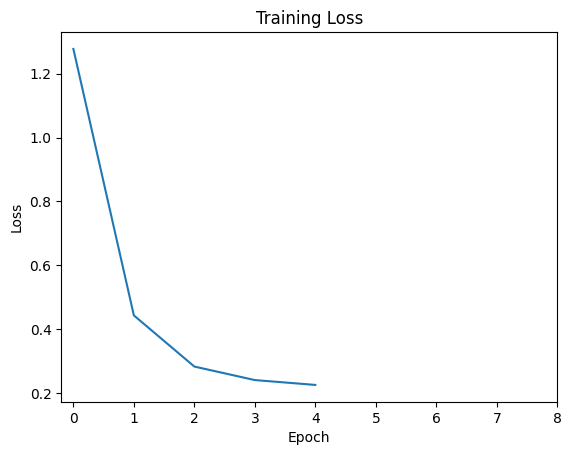

In [52]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.show()

In [53]:
test_texts = test.text.values
test_labels = test.target.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)


prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [54]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

Prediction started on test data
Prediction completed


In [55]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [58]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')
accr = accuracy_score(test_labels, prediction_scores)

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("F-Score Macro: ", f_score)
print("Recall Macro: ", recall)
print("Precision Macro: ", precision)
print("Accuracy: ", accr)
class_names =['INSULT','OTHER','PROFANITY','RACIST','SEXIST']
cm = confusion_matrix(test_labels, prediction_scores, )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

F-Score Macro:  0.9461078257015206
Recall Macro:  0.9488067854267792
Precision Macro:  0.9442745858758668
Accuracy:  0.9467147435897436


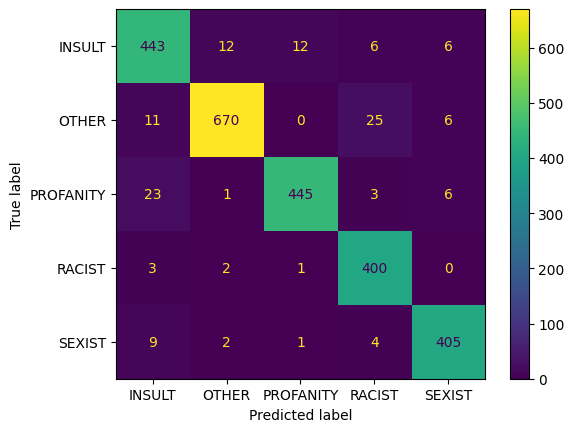

In [64]:
disp.plot();

In [61]:
report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))

In [62]:
report = report.rename(columns={
                                '0':'INSULT',
                                '1':'OTHER',
                                '2':'PROFANITY',
                                '3':'RACIST',
                                '4':'SEXIST'})
report

,INSULT,OTHER,PROFANITY,RACIST,SEXIST,accuracy,macro avg,weighted avg
precision,0.905930,0.975255,0.969499,0.913242,0.957447,0.946715,0.944275,0.947758
recall,0.924843,0.941011,0.930962,0.985222,0.961995,0.946715,0.948807,0.946715
f1-score,0.915289,0.957827,0.949840,0.947867,0.959716,0.946715,0.946108,0.946833
support,479.000000,712.000000,478.000000,406.000000,421.000000,0.946715,2496.000000,2496.000000
